In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score



from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn import preprocessing


import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('../datasets/train.csv')

In [3]:
# check for null, display the columns that has null value detected 
df.loc[:, df.isnull().any()]

# 7 columns with null value detected. 

,Mall_Nearest_Distance,Mall_Within_500m,Mall_Within_1km,Mall_Within_2km,Hawker_Within_500m,Hawker_Within_1km,Hawker_Within_2km
0,1094.090418,NaN,NaN,7.0,1.0,3.0,13.0
1,866.941448,NaN,1.0,3.0,NaN,1.0,7.0
2,1459.579948,NaN,NaN,4.0,NaN,NaN,1.0
3,950.175199,NaN,1.0,4.0,NaN,1.0,9.0
4,729.771895,NaN,1.0,2.0,NaN,NaN,1.0
...,...,...,...,...,...,...,...
150629,585.138715,NaN,4.0,6.0,NaN,1.0,3.0
150630,250.084466,1.0,1.0,4.0,NaN,NaN,1.0
150631,1790.053482,NaN,NaN,2.0,NaN,NaN,4.0
150632,587.244922,NaN,3.0,3.0,1.0,5.0,8.0


In [4]:
# fillna(0) for columns with blank data in rows['Mall_Nearest_Distance'] = df['Mall_Nearest_Distance'].fillna(0)
df.fillna(0, inplace = True)


---
# EDA

In [5]:
dropped_columns = [
    'address',
    'postal',
    'Latitude',
    'Longitude',
    'mrt_latitude',
    'mrt_longitude',
    'bus_stop_latitude',
    'bus_stop_longitude',
    'pri_sch_latitude',
    'pri_sch_longitude',
    'sec_sch_latitude',	
    'sec_sch_longitude'
]
df_dropped = df.drop(columns = dropped_columns)

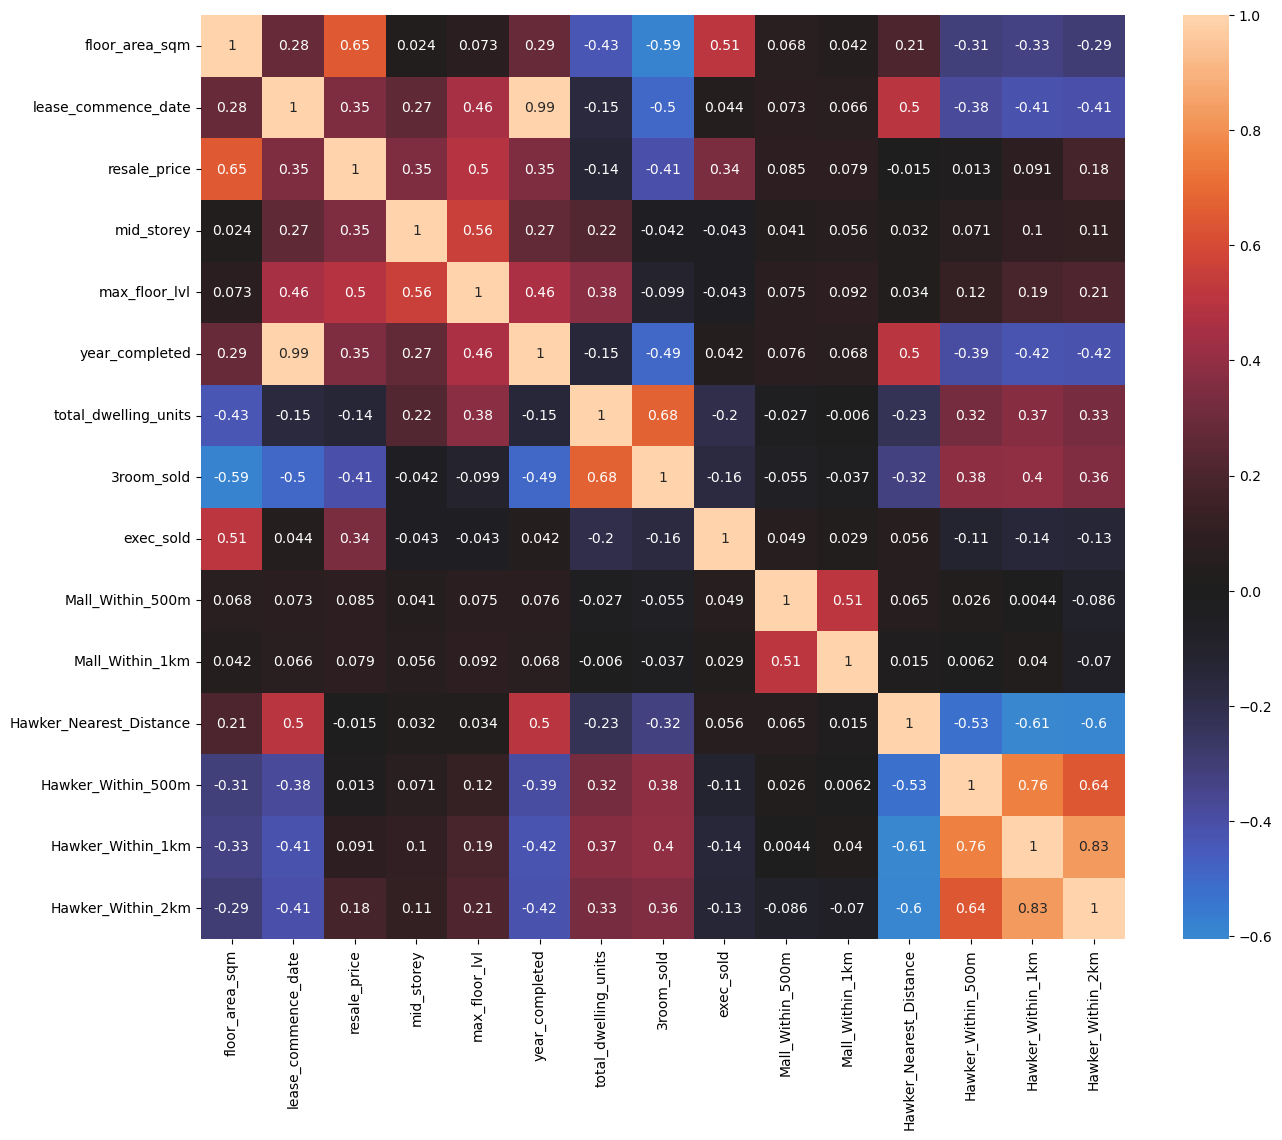

In [6]:
df_num  = df_dropped.select_dtypes(include = 'number')
fig, ax = plt.subplots(figsize=(15,12)) 

# note - 'id','mid','lower','upper','price_per_sqft' are not required for heatmap
df_num  = df_dropped.select_dtypes(include = 'number').drop(columns=['id','mid','lower','upper','price_per_sqft','floor_area_sqft'])
#print(df_num)
# attempt to filter out only numerical columns that has correlation that is more than 0.5
high_corr_columns=df_num.columns[list(df_num.corr().apply( lambda value: value >0.5 ).sum()>1)]
corr=df_num.corr().loc[high_corr_columns,high_corr_columns]
sns.heatmap(corr,square=True,center=0,annot=True, ax=ax)
plt.show()

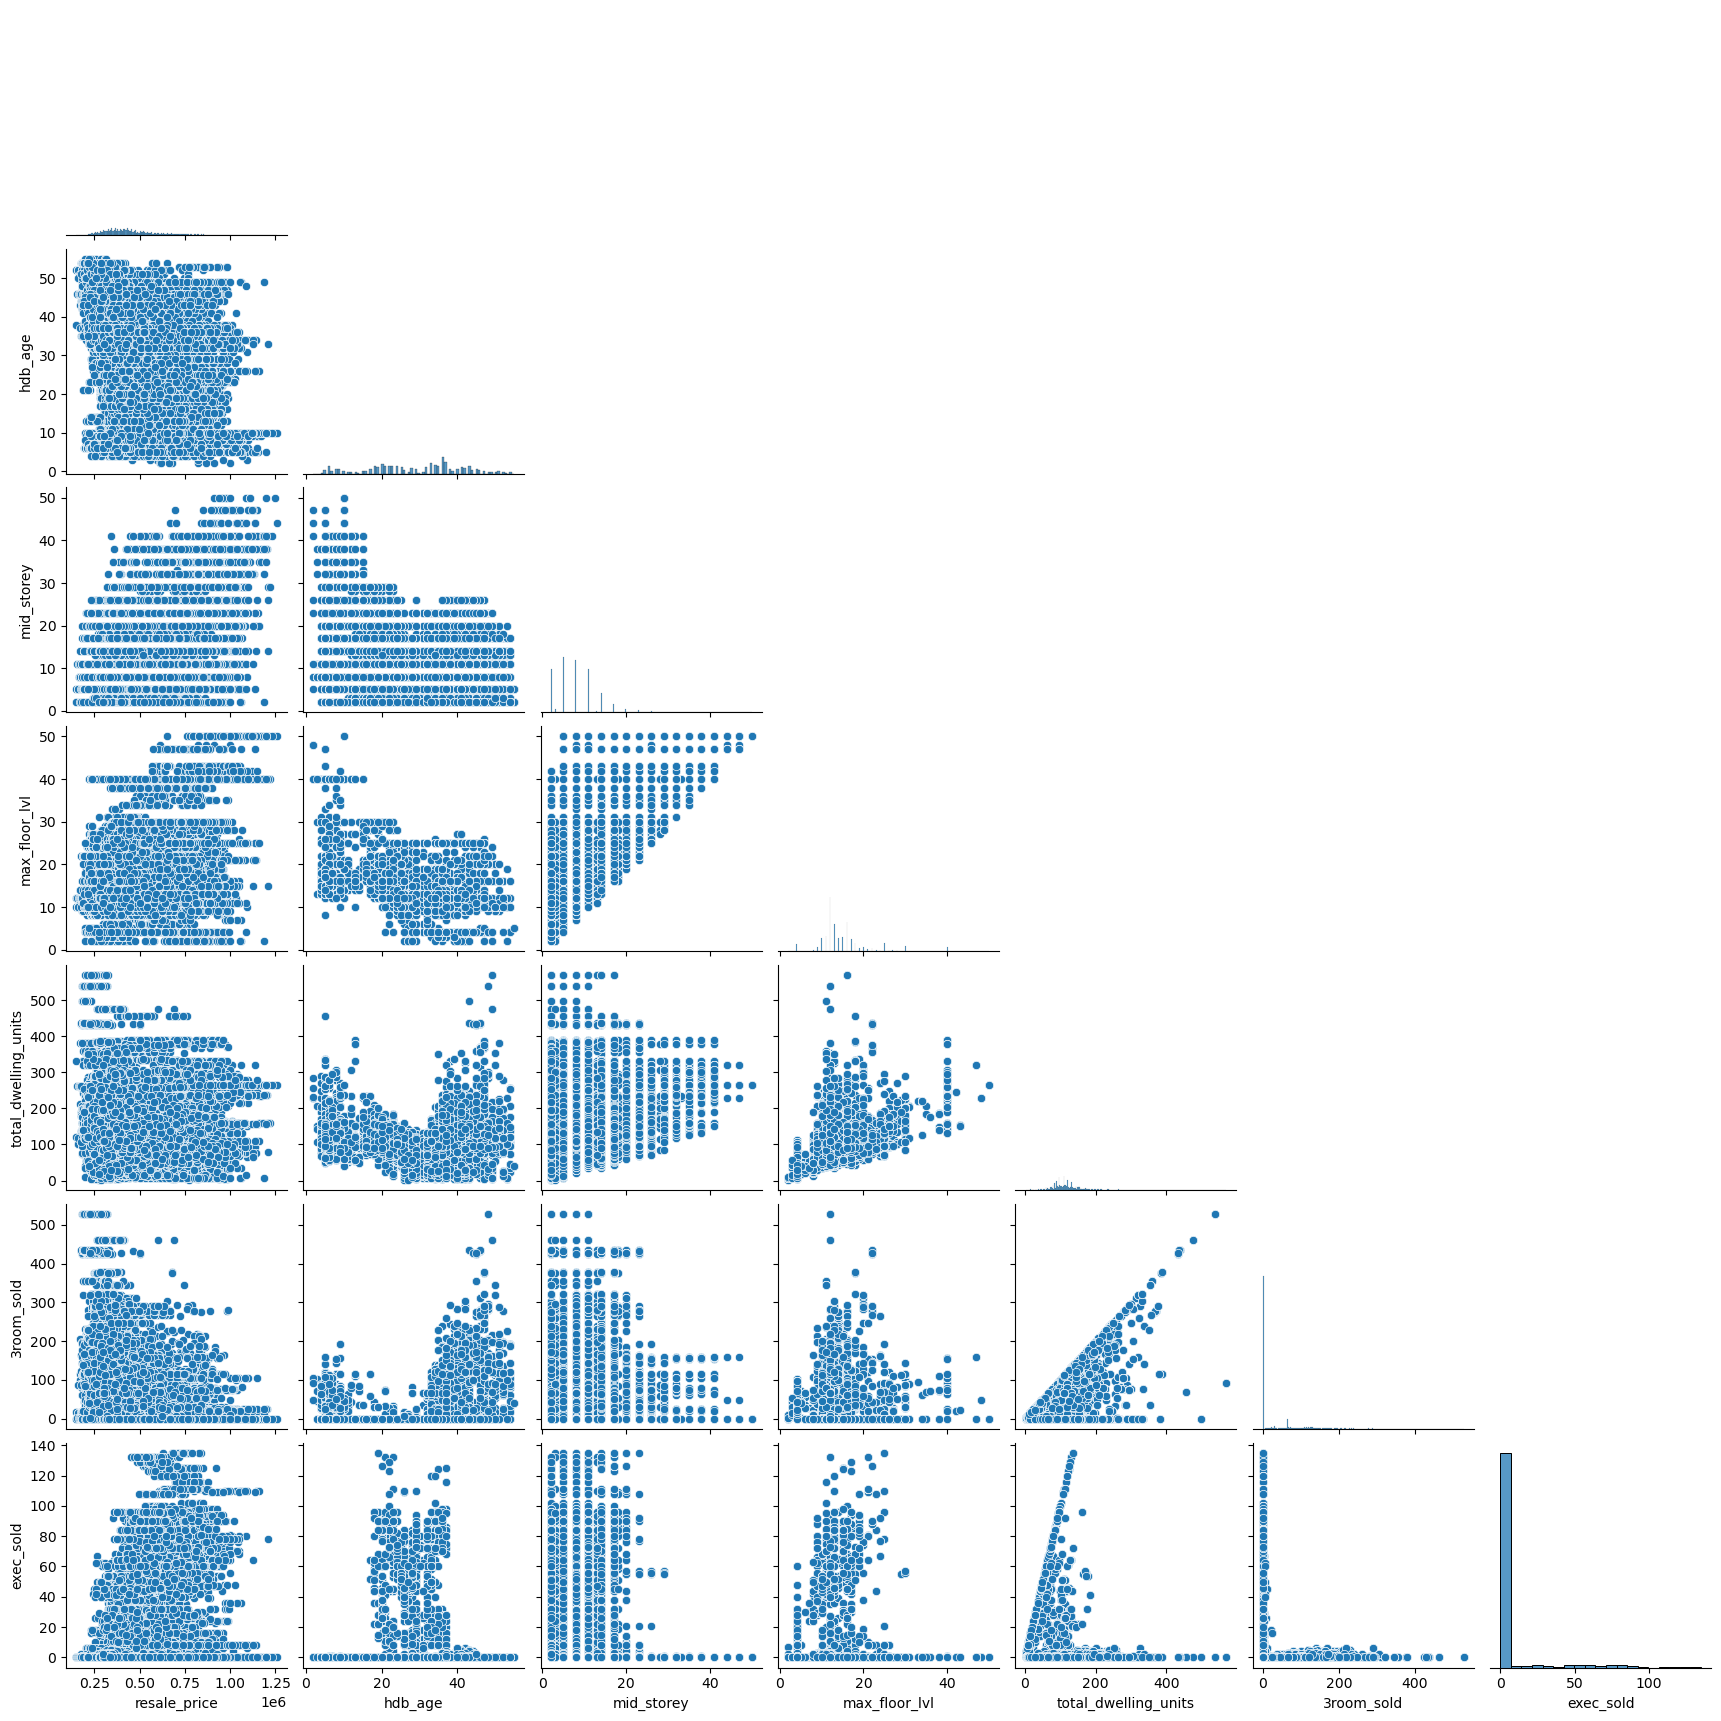

In [7]:
#pairplot to see the predictors having 0.5 correlation against re_sale_price
sns.pairplot(df,
             x_vars = ['resale_price','hdb_age','mid_storey','max_floor_lvl','total_dwelling_units','3room_sold','exec_sold'], 
             y_vars = ['resale_price','hdb_age','mid_storey','max_floor_lvl','total_dwelling_units','3room_sold','exec_sold'],
             corner = True)
plt.show()

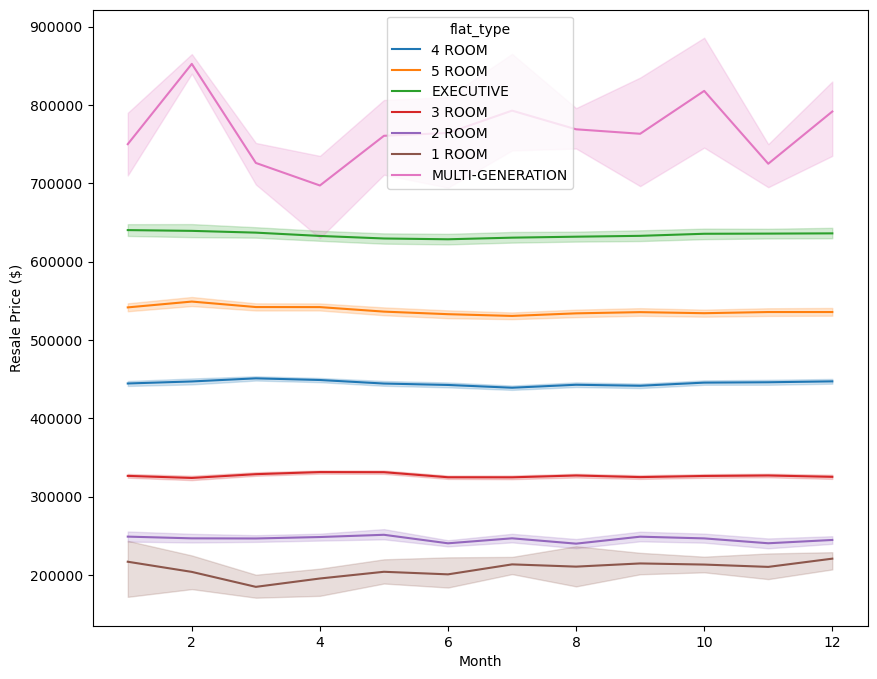

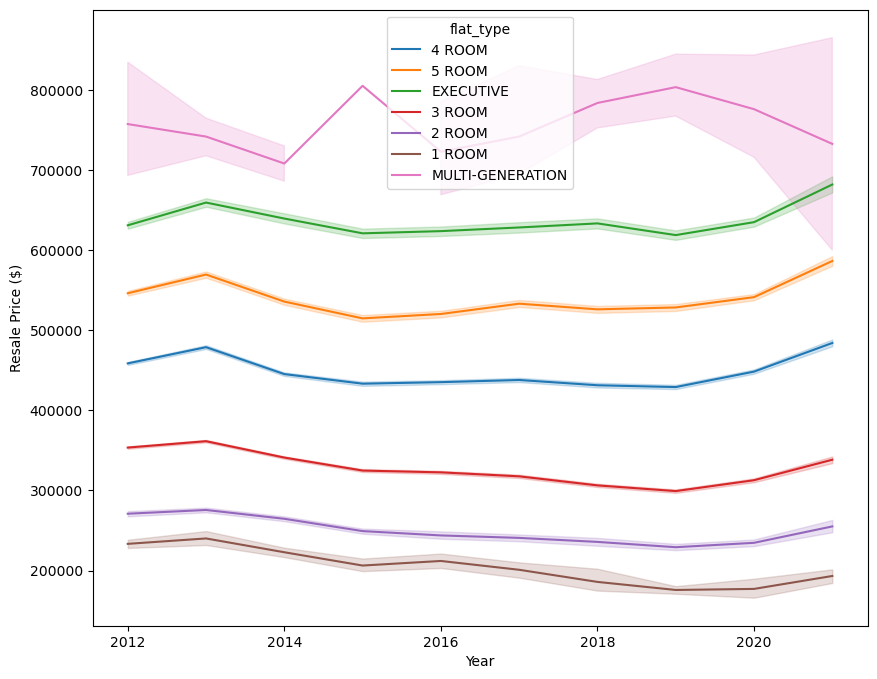

In [8]:
#fig, axes = plt.subplots(nrows = 1, ncols =2, figsize=(16,5))

fig, ax = plt.subplots(figsize=(10,8)) 
sns.lineplot(data=df, x='Tranc_Month', y='resale_price', hue='flat_type')
ax.set(xlabel='Month', ylabel = 'Resale Price ($)')
#ax.set_title(column)
plt.show()

fig, ax = plt.subplots(figsize=(10,8)) 
#ax = axes[1]
sns.lineplot(data=df, x='Tranc_Year', y='resale_price', hue = 'flat_type')
ax.set(xlabel='Year', ylabel = 'Resale Price ($)')

plt.show()

---
# Feature Engineering

New df1 with all the selected features

In [9]:
df1 = df[[
    'resale_price', 'town', 'flat_type', 'floor_area_sqft', 'hdb_age', 'mid_storey', 'max_floor_lvl',
    'Mall_Nearest_Distance', 'Hawker_Nearest_Distance', 
    'mrt_name','Tranc_YearMonth', 'bus_interchange','mrt_nearest_distance']]

In [10]:
#change year month to numeric
df1['Tranc_YearMonth'] = pd.to_numeric(df1['Tranc_YearMonth'].str.replace('-',''))

In [11]:
df['commercial'] = df['commercial'].map(lambda x: 1 if x == 'Y' else 0)
df['market_hawker'] = df['market_hawker'].map(lambda x: 1 if x == 'Y' else 0)

# add following as Features 
df1['Ammenities_same_block'] = df['commercial'] + df['market_hawker']
df1['Ammenities_within_500m'] = df['Mall_Within_500m'] + df['Hawker_Within_500m']
df1['Ammenities_within_1km'] = (df['Mall_Within_1km'] -  df['Mall_Within_500m']) + (df['Hawker_Within_1km'] - df['Hawker_Within_500m'])
df1['Ammenities_within_2km'] = (df['Mall_Within_2km'] - df['Mall_Within_1km'] ) + ( df['Hawker_Within_2km'] - df['Hawker_Within_1km'] )
df1['pri_sch_dist_vacancy'] = df['pri_sch_nearest_distance'] * df['vacancy']
df1['sec_sch_dist_cutoff'] = df['sec_sch_nearest_dist'] * ( 1 / df['cutoff_point'])  # whether numerator stay 1 or 100, the scores remain the same


In [12]:
mrt_colour_dict = {'Kallang': 'green', 'Bishan':['orange','red'], 'Bukit Batok': 'red', 'Khatib': 'red', 'MacPherson': ['orange', 'blue'], 
       'Kovan': 'purple', 'Bedok North': 'blue', 'Marymount':'orange', 'Sengkang': 'purple', 'Buangkok':'purple', 'Tampines': ['green', 'blue'], 
       'Tiong Bahru':'green', 'Bukit Panjang':'blue', 'Marsiling':'red', 'Woodlands South':'brown', 'Admiralty':'red', 'Pioneer':'green', 'Braddell':'red', 
       'Lakeside': 'green', 'Choa Chu Kang': 'red', 'Sembawang': 'red', 'Toa Payoh':'red','Geylang Bahru': 'blue',
       'Yew Tee':'red', 'Ang Mo Kio':'red', 'Telok Blangah':'orange', 'Tampines East':'blue',
       'Potong Pasir':'purple', 'Tampines West':'blue', 'Eunos':'green', 'Yio Chu Kang':'red',
       'Farrer Park':'purple', 'Bukit Gombak':'red', 'Clementi':'green', 'Yishun':'red', 'Punggol':'purple',
       'Jurong East': ['green','red'], 'Tanah Merah':'green', 'Chinese Garden':'green', 'Kembangan':'green',
       'Pasir Ris':'green', 'Jalan Besar':'blue', 'Hougang':'purple', 'Buona Vista':['green','orange'], 'Kaki Bukit':'blue',
       'Cashew':'blue', 'Bedok':'green', 'Boon Keng':'purple', 'Woodlands':'brown', 'Simei':'green', 'Boon Lay':'green',
       'Dakota':'orange', 'Redhill':'green', 'Canberra':'blue', 'Beauty World':'blue', 'Commonwealth':'green',
       'Lorong Chuan':'orange', 'Tai Seng':'orange', 'Bedok Reservoir':'blue', 'Holland Village':'orange',
       'Ubi':'blue', 'HarbourFront':['orange','purple'], 'Dover':'green', 'Chinatown':['blue','purple'], 'Queenstown':'green',
       'Mattar':'blue', 'one-north':'orange', 'Mountbatten':'orange', 'Serangoon':['orange','purple'], 'Farrer Road':'orange',
       'Lavender':'green', 'Outram Park':['green', 'purple'], 'Caldecott':['orange','brown'], 'Aljunied':'green', 'Little India':['blue', 'purple'],
       'Upper Changi':'blue', 'Bartley':'orange', 'Woodlands North':'brown', 'Paya Lebar':['green', 'orange'],
       'Tanjong Pagar':'green', 'Woodleigh':'purple', 'Hillview':'blue', 'Bencoolen':'blue',
       'Labrador Park':'orange', 'Rochor':'blue', 'Nicoll Highway':'orange', 'Clarke Quay':'purple',
       'Tan Kah Kee':'blue', 'Bras Basah':'orange', 'Changi Airport':['green','blue'], 'Bugis':['green','blue'],
       'Bendemeer':'blue', 'Botanic Gardens':['orange', 'blue'], 'Novena':['blue','red'] } 
df1['mrt_colour'] = df['mrt_name'].map(mrt_colour_dict)

In [13]:
region = {'BUKIT BATOK':'west', 'BUKIT PANJANG':'west', 'JURONG WEST':'west', 'CHOA CHU KANG':'west', 'CLEMENTI':'west', 'JURONG EAST':'west', 
          'SEMBAWANG':'north', 'WOODLANDS':'north', 'YISHUN':'north', 
          'HOUGANG':'north_east', 'SENGKANG':'north_east', 'SERANGOON':'north_east', 'PUNGGOL':'north_east', 'ANG MO KIO':'north_east', 
          'BEDOK':'east', 'TAMPINES':'east', 'PASIR RIS':'east', 
          'KALLANG/WHAMPOA':'central', 'BISHAN':'central', 'GEYLANG':'central', 'BUKIT MERAH':'central', 'TOA PAYOH':'central', 'CENTRAL AREA':'central', 'QUEENSTOWN':'central', 'BUKIT TIMAH':'central', 'MARINE PARADE':'central'}
df1['region'] = df1['town'].map(region)

In [14]:
df1.to_csv('../datasets/df1.csv')

In [15]:
df2 = pd.get_dummies(df1, columns =['town'],dtype=int)


In [16]:
df2 = pd.get_dummies(df2, columns =['flat_type'],dtype=int)

In [17]:
#add column counting number of mrt lines 
df2['mrt_no'] = df2.mrt_colour.apply(lambda x: len(x) if isinstance(x,list) else 1) 



In [18]:
df2 = pd.get_dummies(df2,columns = ['region'], dtype = int)

In [19]:
df2.drop(columns =['mrt_name'], inplace = True)

In [20]:
df2.drop(columns =['mrt_colour'], inplace = True)

In [21]:
df2.to_csv('../datasets/df2check.csv',index = False)

In [22]:
#export to csv to share with group
df2.to_csv('../datasets/df2.csv', index = False)